# 2.1 LangChain vs LangGraph (feat. LangGraph 개념 설명)

- LangChain을 활용한 간단한 `llm.invoke()` 예제를 살펴보고, 이를 LangGraph로 구현해보는 과정을 진행합니다.
- LangGraph의 개념과 주요 기능을 이해하고, 두 프레임워크의 차이점을 비교합니다.

## 환경설정

- `LangChain` 활용을 위해 필요한 패키지들을 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [1]:
# %pip install -q python-dotenv langchain-openai

- 먼저 `.env` 파일의 환경변수를 불러옵니다
- `OPENAI_API_KEY`, `GEMINI_API_KEY`, `ANTHROPIC_API_KEY` 등과 같이 환경변수를 설정하면 편하게 사용할 수 있습니다

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

query = '인프런에는 어떤 강의가 있나요?'

llm_openai = ChatOpenAI(model="gpt-4o-mini")
llm_ollama = ChatOllama(model="llama3.1")

response_openai = llm_openai.invoke(query)
response_ollama = llm_ollama.invoke(query)

In [3]:
print(response_openai.content)
print('-'*99)
print(response_ollama.content)

인프런(In프런)은 다양한 온라인 강의를 제공하는 플랫폼입니다. 이곳에서는 프로그래밍, 데이터 과학, 인공지능, 웹 개발, 모바일 앱 개발, UX/UI 디자인 등 여러 분야에 걸쳐 다양한 주제의 강의를 찾아볼 수 있습니다. 

예를 들어, 다음과 같은 분야의 강의가 있을 수 있습니다:

1. **프로그래밍**: Python, Java, C++, JavaScript 등의 언어 강의
2. **웹 개발**: HTML, CSS, React, Node.js, Django 등의 웹 기술 강의
3. **데이터 과학**: 데이터 분석, 머신러닝, 딥러닝 관련 강의
4. **모바일 앱 개발**: Android, iOS 앱 개발 강의
5. **UX/UI 디자인**: 디자인 Thinking, 프로토타이핑 도구 활용 강의
6. **클라우드 컴퓨팅**: AWS, Azure, Google Cloud Platform 관련 강의

구체적인 강의는 인프런 웹사이트를 방문하면 확인할 수 있으며, 최신 강의와 강사 정보도 알림으로 받을 수 있습니다.
---------------------------------------------------------------------------------------------------
인프런은 다양한 테크놀로지, 비즈니스, 프로그래밍, 언어 교육과 같은 분야에 관한 수천 개의 강의를 제공합니다. 가장 인기 있는 강의 중 하나는 "Python programming"이며 프로그래머와 개발자에게 추천되는 코딩 강의입니다.

다음은 인프런에서 가르치는 대표적인 카테고리와 강의 목록입니다.

1.  **인프런 인기 강의**
    *   인공지능(AI), 머신러닝, 딥 러닝
    *   데이터 시각화
    *   프로그래밍(자바, 파이썬 등)
    *   웹 개발
    *   네트워크보안

2.  **인프런 추천 강의**
    *   스타트업, 마케팅, 마케터링
    *   인적 자원 관리
    *   금융 및 투자
    *   데이터 분석 및 가

- `LangGraph` 활용을 위해 필요한 패키지를 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [7]:
# %pip install -q langgraph

- `state`는 LangGraph 에이전트의 state를 나타내는 데이터 구조입니다.
- `state`는 `TypedDict`를 사용하여 정의되며, 이는 Python의 타입 힌팅을 통해 구조를 명확히 합니다.
    - 지금 예제에서는 간단하게 `messages`라는 필드만 있습니다.
    - 필요에 따라 다양한 값들을 활용할 수 있습니다.
        - 2.2 회차에서 다룰 예정입니다.
- `state`는 에이전트의 동작을 결정하는 데 사용되며, 각 노드에서 state를 업데이트하거나 참조할 수 있습니다.
- `state`는 LangGraph의 노드 간에 전달되며, 에이전트의 state 전이를 관리합니다.

In [ ]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]

- 위에 선언한 `AgentState`를 활용하여 `StateGraph`를 생성합니다.

In [ ]:
from langgraph.graph import StateGraph

# graph_builder -> workflow
workflow = StateGraph(state_schema=AgentState)

- `graph`에 추가할 `node`를 생성합니다
-  `node`는 LangGraph에서 실행되는 개별적인 작업 단위를 의미합니다. 
    - 각 노드는 특정 기능을 수행하는 독립적인 컴포넌트로, 예를 들어 텍스트 생성, 데이터 처리, 또는 의사 결정과 같은 작업을 담당할 수 있습니다.
    - `node`는 기본적으로 함수(function)로 정의되고, 뒤에서 다루지만 다른 에이전트(agent)를 활용할 수도 있습니다

In [13]:
def generate(state: AgentState) -> AgentState:
    """
    `generate` 노드는 사용자의 질문을 받아서 응답을 생성하는 노드입니다.
    """
    messages = state["messages"]
    ai_message = llm_ollama.invoke(messages)  # llm_openai
    return {"messages": [ai_message]}

- `node`를 생성한 후에 `edge`로 연결합니다
- `edge`는 노드들 사이의 연결을 나타내며, 데이터와 제어 흐름의 경로를 정의합니다. 
    - 엣지를 통해 한 노드의 출력이 다음 노드의 입력으로 전달되어, 전체적인 워크플로우가 형성됩니다.
    - `node`와 `edge`의 조합은 방향성 그래프(Directed Graph)를 형성하며, 이를 통해 복잡한 AI 에이전트의 행동 흐름을 구조화할 수 있습니다

- 모든 그래프는 `START(시작)`와 `END(종료)`가 있습니다
    - `END`를 explicit하게 선언하지 않는 경우도 종종 있지만, 가독성을 위해 작성해주는 것을 권장합니다

In [14]:
from langgraph.graph import START, END

workflow.add_node('generate', generate)  # (node, action)
workflow.add_edge(START, 'generate')
workflow.add_edge('generate', END)

- `node`를 생성하고 `edge`로 연결한 후에 `compile` 메서드를 호출하여 `Graph`를 생성합니다

In [15]:
graph = workflow.compile()

- `compile` 후에는 그래프를 시각화하여 확인할 수 있습니다
- 의도한대로 그래프가 생성됐는지 확인하는 습관을 기르는 것이 좋습니다
    - `git`에서 코드 작업물을 commit하기 전에 `git diff`를 통해 변경사항을 확인하는 것과 같습니다

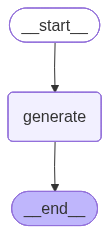

In [16]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
# AnyMessage = HumanMessage, AIMessage, SystemMessage, ToolMessage, FunctionMessage, AIMessageChunk, HumanMessageChunk
from langchain_core.messages import HumanMessage

# query = '인프런에는 어떤 강의가 있나요?'
inputs = {"messages": [HumanMessage(query)]}  # initial_state -> inputs
response = graph.invoke(input=inputs)
response

{'messages': [AIMessage(content='인프런에 있는 강의는 수십만 개가 넘습니다. \n\n인프런에서 가장 인기있는 강좌는 다음과 같습니다.\n\n1.  **코딩** - 인프런에서 코딩과 프로그래밍을 공부할 수 있습니다. 개발자로 성장하고 싶은 사람들에게 유용한 정보를 제공하는 강의가 많으며, 다양한 언어(Java, Python, JavaScript 등)의 강의가 있습니다.\n2.  **마케팅** - 마케팅에 대한 지식을 습득할 수 있는 강좌들이 있습니다. 이 강좌들은 마케팅 전략, 소셜 미디어 마케팅, SEO, 비즈니스 분석 등 다양한 주제로 구성되어 있습니다.\n3.  **리더십** - 리더십 강의는 개인과 팀을 이끌고 싶은 사람들에게 유용한 정보를 제공합니다. 인성을 기르기 위한 방법부터 팀 관리까지 다양한 주제가 포함되어 있습니다.\n4.  **회계** - 회계 강좌에서는 비즈니스와 관련된 금융 및 회계 지식을 배울 수 있습니다. 이 강좌들은 예산 계획, 재무 분석, 금융 통치 등에 관한 정보를 제공합니다.\n5.  **디자인** - 디자이너로 성장하고 싶은 사람들에게 추천하는 강의입니다. UI/UX 디자인부터 그래픽 디자인까지 다양한 주제의 강의가 있습니다.\n\n이 외에도 인프런에는 마이크로서비스 아키텍처, 자바 스프링 프레임워크, 클라우드 컴퓨팅, 인공지능(AI), 머신러닝 등 다양한 분야에 대한 강의들이 있으니, 개인의 관심사에 맞는 강좌를 선택하시면 좋을 것입니다.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-12-06T01:53:20.1748121Z', 'done': True, 'done_reason': 'stop', 'total_duration': 33161323600, 'load_duration': 98171200, 'prompt_eval_count': 21, 'prompt_eval_duration': 1145280

In [25]:
print(response["messages"][-1].content)

인프런에 있는 강의는 수십만 개가 넘습니다. 

인프런에서 가장 인기있는 강좌는 다음과 같습니다.

1.  **코딩** - 인프런에서 코딩과 프로그래밍을 공부할 수 있습니다. 개발자로 성장하고 싶은 사람들에게 유용한 정보를 제공하는 강의가 많으며, 다양한 언어(Java, Python, JavaScript 등)의 강의가 있습니다.
2.  **마케팅** - 마케팅에 대한 지식을 습득할 수 있는 강좌들이 있습니다. 이 강좌들은 마케팅 전략, 소셜 미디어 마케팅, SEO, 비즈니스 분석 등 다양한 주제로 구성되어 있습니다.
3.  **리더십** - 리더십 강의는 개인과 팀을 이끌고 싶은 사람들에게 유용한 정보를 제공합니다. 인성을 기르기 위한 방법부터 팀 관리까지 다양한 주제가 포함되어 있습니다.
4.  **회계** - 회계 강좌에서는 비즈니스와 관련된 금융 및 회계 지식을 배울 수 있습니다. 이 강좌들은 예산 계획, 재무 분석, 금융 통치 등에 관한 정보를 제공합니다.
5.  **디자인** - 디자이너로 성장하고 싶은 사람들에게 추천하는 강의입니다. UI/UX 디자인부터 그래픽 디자인까지 다양한 주제의 강의가 있습니다.

이 외에도 인프런에는 마이크로서비스 아키텍처, 자바 스프링 프레임워크, 클라우드 컴퓨팅, 인공지능(AI), 머신러닝 등 다양한 분야에 대한 강의들이 있으니, 개인의 관심사에 맞는 강좌를 선택하시면 좋을 것입니다.
